In [155]:
#Librerias a utilizar
import sys
import os
import argparse

import random
import datetime

from collections import Counter

import numpy as np

import pandas as pd

import shutil

from tqdm import tqdm

import inspect
import gc

import re

from PIL import Image

import cv2

# Importamos keras, libreria usada para el procesamiento de imagenes y modelos
import keras
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, GlobalAveragePooling1D, GlobalAveragePooling2D, Flatten, BatchNormalization, Dense
from keras.applications.inception_v3 import InceptionV3
from keras.constraints import maxnorm

# Importamos la utileria para procesar los datos y las imagenes
from keras import optimizers
from keras import backend as K
K.set_image_data_format('channels_first')
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier

# Importamos la utileria de sklean que nos servira para sacar presiciones, f1, matriz de confusion, reportes de clasificacion, etc.
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix

# Importamos tensorflow
from tensorflow.keras.optimizers import Adam
import tensorflow.compat.v1 as tf

from IPython.display import display

import seaborn as sns

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# Funcion necesaria para que nuestros plots se pinten en el notebook
%matplotlib inline

print('---- Librerias importadas correctamente ----')


---- Librerias importadas correctamente ----


In [156]:
# Funcion auxiliar que crea un directorio, si este existe se elimina si el remover = True
def create_directory(ruta, remove=False):
    if remove and os.path.exists(ruta):
        try:
            shutil.rmtree(ruta)
            os.makedirs(ruta)
        except:
            print("No se puede eliminar el directorio : ", ruta)
            return False
    else:
        try:
            os.makedirs(ruta)
        except:
            print("No se puede crear un directorio en la ruta: ", ruta)
            return False
        
    return True

# Funcion que remueve un directorio si este existe
def clear_directory(ruta):
    if os.path.exists(ruta):
        try:
            shutil.rmtree(ruta)
        except:
            print("No se puede eliminar el directorio en la ruta : ", ruta)
            return False
        
    return True

# Funcion que limpia una carpeta
def limpiar_carpeta(ruta):
    dirs_files = os.listdir(ruta)
    
    for item in dirs_files:
#         item_path = os.path.join(directory_path, item)
        item_path = ruta + item
        
        try:
            if os.path.isfile(item_path):
                os.unlink(item_path)
            elif os.path.isdir(item_path): 
                shutil.rmtree(item_path)
        except Exception as e:
            print(e)
            
    return True

# Remover carpetas vacias
def remove_empty_folders(ruta, removeRoot=True):
    if not os.path.isdir(ruta):
        return
    
    # remover hijos vacios
    files = os.listdir(ruta)
    
    if len(files):
        for f in files:
            fullpath = os.path.join(ruta, f)
            
            if os.path.isdir(fullpath):
                remove_empty_folders(fullpath)

    # si el folder esta vacio se elimina
    files = os.listdir(ruta)
    
    if len(files) == 0 and removeRoot:
        print("Removiendo folder vacio:", ruta)
        os.rmdir(ruta)

# Contar cantidad de archivos de un directorio
def dir_file_count(folder):
    return sum([len(files) for r, d, files in os.walk(folder)])

# Imprimir fechas en diferentes formatos prestablecidos
def date_time(x):
    if x==1:
        return 'Fecha: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==2:    
        return 'Fecha: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==3:  
        return 'Fecha ahora: %s' % datetime.datetime.now()
    if x==4:  
        return 'Fecha hoy: %s' % datetime.date.today()
    
# Imprime un entero para eldebugger
def debug(x):
    print("-"*40, x, "-"*40)
    
# Remueve todo a excepcion de caracteres señeccionados
def name_correct(name):
    return re.sub(r'[^a-zA-Z,:]', ' ', name).title()


In [157]:
# Visualizacion de datos, resetea parametros de los plots hijos
def get_reset_subplot_params(nrows, ncols, dpi):
    subplot_params = {}
    subplot_params["nrows"] = nrows
    subplot_params["ncols"] = ncols

    subplot_params["figsize_col"] = subplot_params["ncols"]*2.5
    subplot_params["figsize_row"] = subplot_params["nrows"]*2.5
    subplot_params["dpi"] = dpi
    subplot_params["facecolor"] = 'w'
    subplot_params["edgecolor"] = 'k'
    subplot_params["subplot_kw"] = {'xticks': [], 'yticks': []}
    subplot_params["axes.titlesize"] = 'small'
    subplot_params["hspace"] = 0.5
    subplot_params["wspace"] = 0.3
    
    return subplot_params

# Visualizacion de datos, resetea parametros de los plots padres
def get_reset_plot_params(figsize=(15, 5), title="", xlabel ="", ylabel="", legends=[], title_fontsize = 18, label_fontsize = 14, image_file_name="", save = False, dpi=100, update_image=True):
    plot_params = {}
    
    plot_params["figsize"] = figsize
    plot_params["title"] = title
    
    plot_params["xlabel"] = xlabel
    plot_params["ylabel"] = ylabel
    
    plot_params["legends"] = legends 
    
    plot_params["title_fontsize"] = title_fontsize
    plot_params["axes.titlesize"] = "small"
    plot_params["label_fontsize"] = label_fontsize
    
    plot_params["image_file_name"] = image_file_name
    plot_params["save"] = save
    plot_params["update_image"] = update_image
    
    plot_params["subplot"] = None
    
    return plot_params

In [158]:
# Seleccionar imagen por categoria
def select_image_by_category(image_dir, image_count_per_category):
    classes = os.listdir(image_dir)
    class_count = len(classes)

    image_file_paths = {}
    
    for i in range(class_count):
        subdir_path = image_dir+"/"+classes[i]
        subdir_files = os.listdir(subdir_path)

        subdir_file_count = len(subdir_files)

        subdir_file_mem = {}
        
        subdir_file_index = -1
        
        image_file_paths[classes[i]] = []
        
        for j in range(image_count_per_category):
            while subdir_file_index in subdir_file_mem:
                subdir_file_index = random.randint(0, subdir_file_count-1)
                
            subdir_file_mem[subdir_file_index] = 1
            
            subdir_file_name = subdir_files[subdir_file_index]
            subdir_file_path = subdir_path+ "/" + subdir_file_name

            image_file_paths[classes[i]].append(subdir_file_path)
            
    return image_file_paths

def get_fig_axs(subplot_params):
    fig, axs = plt.subplots(
        nrows=subplot_params["nrows"], ncols=subplot_params["ncols"], 
        figsize=(subplot_params["figsize_col"], subplot_params["figsize_row"]),
        dpi=subplot_params["dpi"], facecolor=subplot_params["facecolor"], 
        edgecolor=subplot_params["edgecolor"], subplot_kw=subplot_params["subplot_kw"])
        
    return fig, axs

# Plot para las imagenes
def plot_sample_image(image_file_paths, plot_params, subplot_params, update_image=True):
    fig, axs = get_fig_axs(subplot_params)

    plt.rcParams.update({'axes.titlesize': plot_params["axes.titlesize"]})
    plt.subplots_adjust(hspace=subplot_params["hspace"], wspace=subplot_params["wspace"])


    i=0
    for img_filepath in image_file_paths:
        img = cv2.imread(img_filepath, 1)
        plt.title(img_filepath.split("/")[-1])
        plt.subplot(subplot_params["nrows"], subplot_params["ncols"], i+1)
        plt.imshow(img)
        
        plt.xticks([])
        plt.yticks([])
        
        i=i+1
        
    if plot_params["update_image"] and os.path.exists(plot_params["image_file_name"]):
        os.remove(plot_params["image_file_name"])  
    if plot_params["save"]:
        fig.savefig(plot_params["image_file_name"], dpi=plot_params["dpi"])
        
    plt.tight_layout()
    plt.show()
    
# Mostrar imagenes por clase
def show_class_sample_images(directory, image_count_per_category=5, save=False, dpi=100, update_image=False):
    class_count = len(os.listdir(directory))
    print("Number of Class: ", class_count)
    sample_img_by_class = select_image_by_category(directory, image_count_per_category)
    for class_name in sample_img_by_class:
        plot_params = get_reset_plot_params(image_file_name="img.png", save = save, dpi=dpi, update_image=update_image)
        subplot_params = get_reset_subplot_params(nrows=1, ncols=image_count_per_category, dpi=dpi)
        print("%s%s%s"%("-"*55, name_correct(class_name), "-"*55))
        plot_sample_image(sample_img_by_class[class_name], plot_params, subplot_params)
        print("")
    
    print("%s%s%d%s"%("-"*55, "All Class Printed:", class_count, "-"*55))
    
print("")
  
# Cuenta el numero de archivos en cada directorio hijo de un directorio padre
def subdirectory_file_count(master_directory):
    subdirectories = os.listdir(master_directory)
    subdirectory_count = len(subdirectories)

    subdirectory_names = []
    subdirectory_file_counts = []

    for subdirectory in subdirectories:
        current_directory = os.path.join(master_directory, subdirectory)
        file_count = len(os.listdir(current_directory))
        subdirectory_names.append(subdirectory)
        subdirectory_file_counts.append(file_count)
    
    return subdirectory_names, subdirectory_file_counts

# Plot de barra
def bar_plot(x, y, plot_property):
    if plot_property['subplot']:
        plt.subplot(plot_property['subplot'])
    sns.barplot(x=x, y=y)
    plt.title(plot_property['title'], fontsize=plot_property['title_fontsize'])
    plt.xlabel(plot_property['xlabel'], fontsize=plot_property['label_fontsize'])
    plt.ylabel(plot_property['ylabel'], fontsize=plot_property['label_fontsize'])
    plt.xticks(range(len(x)), x)
    
# Mostrar el contador de archivos encontrados en cada subdirectorio
def count_bar_plot(master_directory, plot_property):
    dir_name, dir_file_count = subdirectory_file_count(master_directory)
    x = [name_correct(i) for i in dir_name]
    # x = dir_name
    y = dir_file_count
    bar_plot(x, y, plot_property)
    
# Muestra un contador para cada subdirectorio en los directorios de training, validacion y testing
def show_train_val_test(training_dir, validation_dir, testing_dir, plot_property):
    plt.figure(figsize=plot_property['figsize'])
    
    title = plot_property['title']
    plot_property['title'] = title + " (Entrenamiento)"
    subplot_no = plot_property['subplot'] 

    count_bar_plot(training_dir, plot_property)
    
    
    plot_property['title'] = title + " (Validacion)"
    plot_property['subplot'] = subplot_no+1
    count_bar_plot(validation_dir, plot_property)
    
    
    plot_property['title'] = title + " (Pruebas)"
    plot_property['subplot'] = subplot_no + 2
    count_bar_plot(testing_dir, plot_property)
    
    plt.show()
    
# Metodo para restablecer el grafico de tensorflow y liberar recursos
def reset_graph(model=None):
    if model:
        try:
            del model
        except:
            return False
    
    tf.reset_default_graph()
    
    K.clear_session()
    
    gc.collect()
    
    return True

# Restablece las llamadas a los metodos
def reset_callbacks(checkpoint=None, reduce_lr=None, early_stopping=None, tensorboard=None):
    checkpoint = None
    reduce_lr = None
    early_stopping = None
    tensorboard = None

# Etapa de preprocesado

In [159]:
# Primero llamamos a los metodos que se encargan de reiniciar tensorflow, esto con el fin de liberar recursos

reset_graph()
reset_callbacks()

# Configuramos los directorios de entrada o salida de datos
# Configure training, validation, testing directory

input_directory = r"data/input/"
output_directory = r"data/output/"

training_dir = input_directory + r"train"
validation_dir = input_directory + r"val"
testing_dir = input_directory + r"test"

figure_directory = r"data\output\figures"

figure_directory = "data/output/figures"
if not os.path.exists(figure_directory):
    os.makedirs(figure_directory)
    
file_name_pred_batch = figure_directory+r"/result"
file_name_pred_sample = figure_directory+r"/sample"

Number of Class:  2
-------------------------------------------------------Normal-------------------------------------------------------


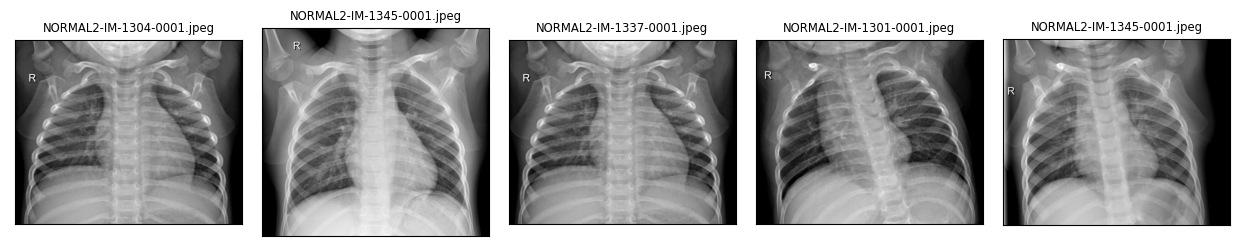


-------------------------------------------------------Pheumonia-------------------------------------------------------


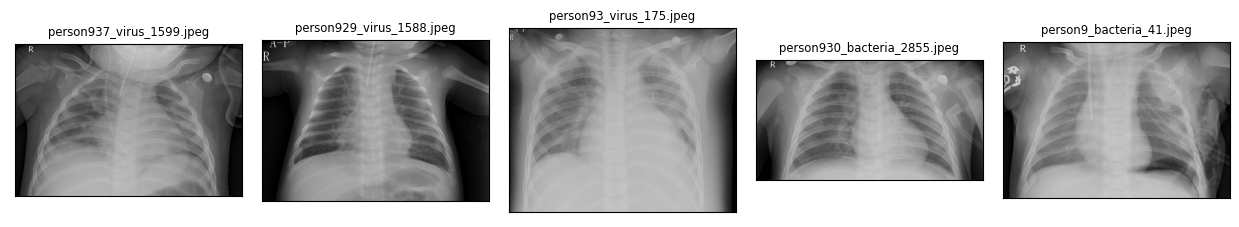


-------------------------------------------------------All Class Printed:2-------------------------------------------------------


In [160]:
show_class_sample_images(training_dir, image_count_per_category=5, save=False, dpi=100, update_image=False)

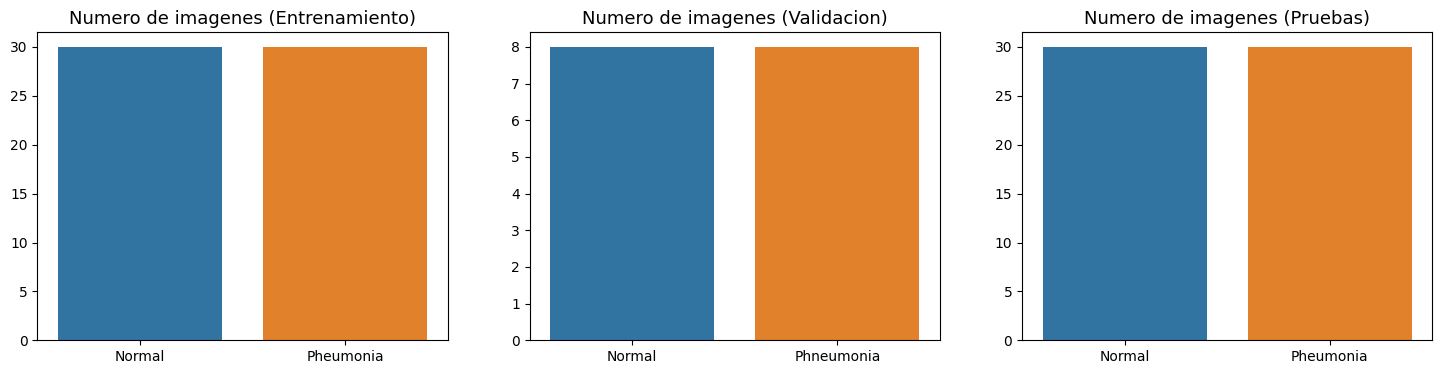

In [161]:
plot_params = get_reset_plot_params()
plot_params['figsize'] = (18,4)
plot_params['title_fontsize'] = 13
plot_params['label_fontsize'] = 10
plot_params['title'] = "Numero de imagenes"

plot_params['subplot'] = 131

show_train_val_test(training_dir, validation_dir, testing_dir, plot_params)
classes = os.listdir(training_dir)
classes = [name_correct(i) for i in classes]

# Procesado de imagenes, aumento de imagenes y transformacion para los diferentes modelos de entrenamiento (evolutivo)

In [162]:
rescale = 1./255
target_size = (150, 150)
batch_size = 163
class_mode = "categorical"

train_datagen = ImageDataGenerator(
    rescale=rescale,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle=True)

validation_datagen = ImageDataGenerator(rescale=rescale)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=dir_file_count(validation_dir),
    shuffle = False)

test_datagen = ImageDataGenerator(rescale=rescale)

test_generator = test_datagen.flow_from_directory(
    testing_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=dir_file_count(testing_dir),
    shuffle = False)

Found 60 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


In [163]:
from sklearn.utils import class_weight
def get_weight(y):
    class_weight_current = class_weight.compute_class_weight(class_weight = "balanced", classes= np.unique(y), y= y)
    class_weight_dict = dict(enumerate(class_weight_current))
    return class_weight_dict

In [164]:
class_weight = get_weight(train_generator.classes)
class_weight

{0: 1.0, 1: 1.0}

# Configuracion para el entrenamiento

In [165]:
import time

main_model_dir = output_directory + r"models/"
main_log_dir = output_directory + r"logs/"

clear_directory(main_log_dir)
remove_empty_folders(main_model_dir, False)

model_dir = main_model_dir + time.strftime('%Y-%m-%d %H-%M-%S') + "/"
log_dir = main_log_dir + time.strftime('%Y-%m-%d %H-%M-%S')

create_directory(model_dir, remove=True)
create_directory(log_dir, remove=True)

# Nombre del modelo a establecer
model_file = model_dir + "{epoch:02d}-val_accuracy-{val_accuracy:.2f}-val_loss-{val_loss:.2f}.hdf5"

In [166]:
# Limpiamos el motor de tensorflow
reset_graph()
reset_callbacks()

In [167]:
checkpoint = ModelCheckpoint(
    model_file, 
    monitor='val_accuracy', 
    save_best_only=True)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True)


tensorboard = TensorBoard(
    log_dir=log_dir,
    update_freq = 'batch')


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=5,
    cooldown=2,
    min_lr=0.0000000001,
    verbose=1)


#-----------------------------------------------------------------------------------------------------------------#
callbacks = [checkpoint, reduce_lr, early_stopping, tensorboard]
# callbacks = [checkpoint, tensorboard]
#-----------------------------------------------------------------------------------------------------------------#
print("Estableciendo datos de tensorflow", date_time(1))

Estableciendo datos de tensorflow Fecha: 2022-11-25 03:38:05


In [168]:
# Creamos el modelo de la red convolucional ayudandonos del modelo evolutivo anteriormente creado
def get_conv_model():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(3,150,150)))
    model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))

    model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(3,150,150)))
    model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))

    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))

    model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
    model.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))

    model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
    model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))

    model.add(Flatten())

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(2 , activation='softmax'))


    print(model.summary())
    
    return model

In [169]:
# Cargamos y configuramos el modelo InceptionV3 y se ajusta con las etiquetas de clase
def get_model(): 
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    x = base_model.output
    x = BatchNormalization()(x)
    predictions = Dense(2, activation='softmax')(x) 
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    
    model.summary()
        
    return model



# Entrenamos el modelo previamente creado (InceptionV3 con las nuevas etiquetas)

In [170]:
print("Obteniendo modelo base", date_time(1))
model = get_conv_model()

Obteniendo modelo base Fecha: 2022-11-25 03:38:05
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 150, 150)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 150, 150)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 75, 150)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 75, 150)       2336      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 75, 150)       9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 37, 150)       0         
_________________________________________________________________
conv2d

In [171]:
# Iniciamos la fase de entrenamiento
print("Iniciando fase de entrenamiento", date_time(1))
steps_per_epoch=len(train_generator)
validation_steps=len(validation_generator)

# Mandamos parametros para red neuronal coevolucional
optimizer=Adam()
loss='categorical_crossentropy'
metrics=['accuracy']
epochs = 100

model.compile(optimizer, loss=loss, metrics=metrics)

history = model.fit(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs=epochs,
    verbose=2,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=validation_steps, 
    class_weight=class_weight)

print("Fase de entrenamiento completada", date_time(1))

Iniciando fase de entrenamiento Fecha: 2022-11-25 03:38:05
Epoch 1/100
1/1 - 9s - loss: 0.6931 - accuracy: 0.4833 - val_loss: 0.6986 - val_accuracy: 0.5000
Epoch 2/100
1/1 - 4s - loss: 0.6877 - accuracy: 0.5500 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 3/100
1/1 - 2s - loss: 0.7166 - accuracy: 0.4333 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 4/100
1/1 - 1s - loss: 0.6945 - accuracy: 0.4833 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/100
1/1 - 2s - loss: 0.6939 - accuracy: 0.5167 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/100
1/1 - 1s - loss: 0.6939 - accuracy: 0.4833 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 7/100
1/1 - 2s - loss: 0.6926 - accuracy: 0.5500 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 8/100
1/1 - 1s - loss: 0.6926 - accuracy: 0.5167 - val_loss: 0.6929 - val_accuracy: 0.5000

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 9/100
1/1 - 1s - loss: 0.6938 - accuracy: 0.5167 - val_loss: 0.6928 - val_acc

# Visualizacion del rendimiento de la CNN a lo largo del entrenamiento

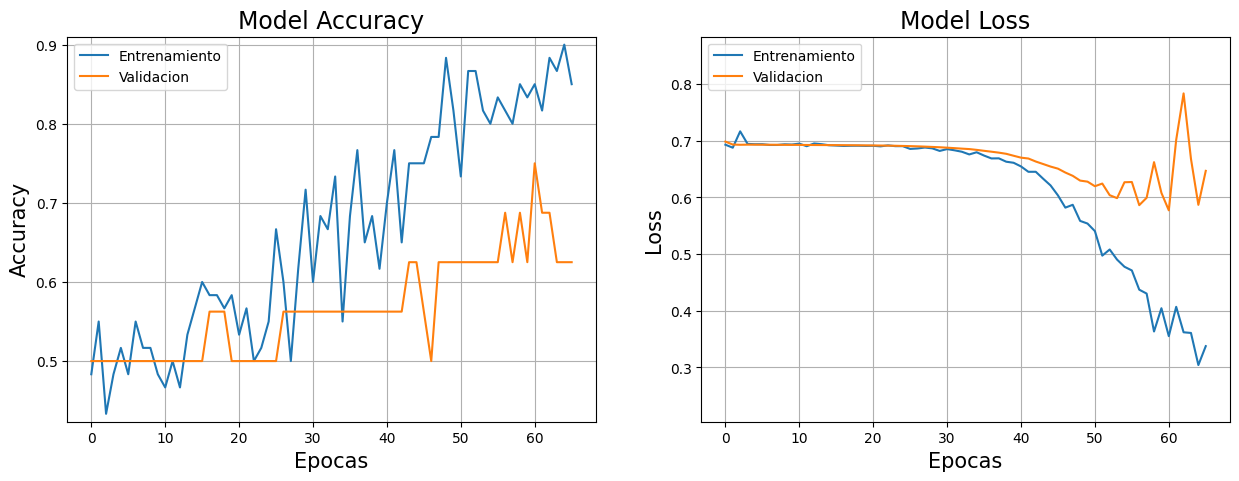

In [172]:
xlabel = 'Epocas'
legends = ['Entrenamiento', 'Validacion']

ylim_pad = [0.01, 0.1]


plt.figure(figsize=(15, 5))

# Plot training & validation Accuracy values

y1 = history.history['accuracy']
y2 = history.history['val_accuracy']

min_y = min(min(y1), min(y2))-ylim_pad[0]
max_y = max(max(y1), max(y2))+ylim_pad[0]

plt.subplot(121)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Accuracy', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()

# Plot training & validation loss values
    
y1 = history.history['loss']
y2 = history.history['val_loss']

min_y = min(min(y1), min(y2))-ylim_pad[1]
max_y = max(max(y1), max(y2))+ylim_pad[1]
    
    
plt.subplot(122)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Loss', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()
                         
plt.show()

## Probar modelos guardados

In [173]:
dir_name = r"data/output/models/"
dirs = os.listdir(dir_name)
for i in range(len(dirs)):
    print(i, dirs[i])

0 2022-11-25 00-57-44
1 2022-11-25 03-15-05
2 2022-11-25 03-22-52
3 2022-11-25 03-32-15
4 2022-11-25 03-38-04


In [174]:
cur_dir =dir_name+dirs[0]+"/"
model_names = os.listdir(cur_dir)
for i in range(len(model_names)):
    print(i, model_names[i])

0 01-val_accuracy-0.50-val_loss-0.69.hdf5


In [175]:
model_file = cur_dir+model_names[0]

print(model_file)

data/output/models/2022-11-25 00-57-44/01-val_accuracy-0.50-val_loss-0.69.hdf5


In [176]:
model = keras.models.load_model(model_file)

In [177]:
print("results")
result  = model.evaluate(test_generator, steps=len(test_generator), verbose=1)

print("%s%.2f  "% ("Loss     : ", result[0]))
print("%s%.2f%s"% ("Accuracy : ", result[1]*100, "%"))

results
1/1 [==============================] - 1s 1s/step - loss: 0.6960 - accuracy: 0.5000
Loss     : 0.70  
Accuracy : 50.00%


In [178]:
print("results")
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)  
y_pred = y_pred.argmax(axis=-1)
y_true=test_generator.classes

results
1/1 [==============================] - 1s 624ms/step


------------------------------------------------------------------------------------------
Reporte total
------------------------------------------------------------------------------------------
Precision     : 50.00%
Exhaustividad : 100.00%
Valor-F       : 66.67%
------------------------------------------------------------------------------------------





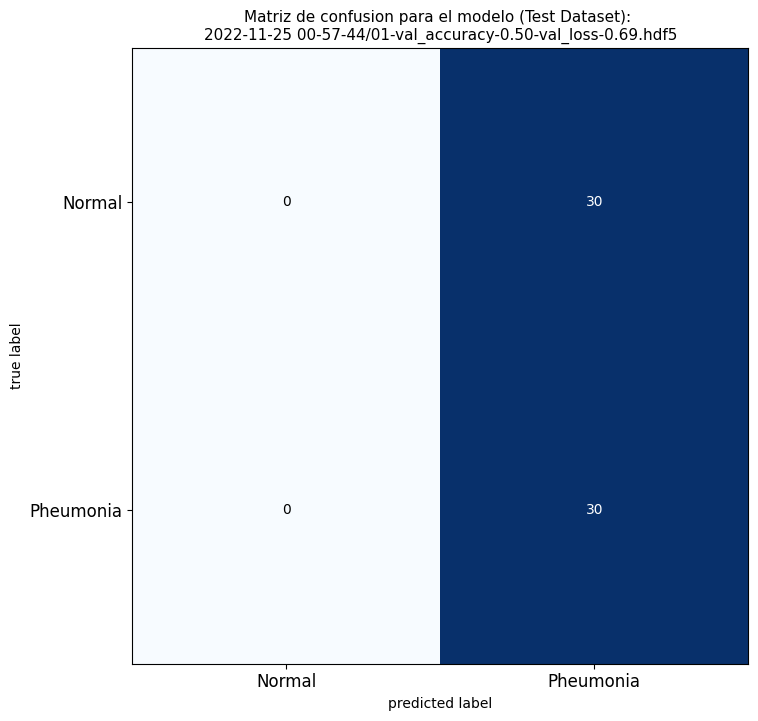




------------------------------------------------------------------------------------------
Report for Model File:  2022-11-25 00-57-44/01-val_accuracy-0.50-val_loss-0.69.hdf5
------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00        30
   Pheumonia       0.50      1.00      0.67        30

    accuracy                           0.50        60
   macro avg       0.25      0.50      0.33        60
weighted avg       0.25      0.50      0.33        60

------------------------------------------------------------------------------------------


C:\Users\kenit\anaconda3\envs\gputensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kenit\anaconda3\envs\gputensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kenit\anaconda3\envs\gputensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [179]:
# Matriz de confusion

image_file_name_CM = figure_directory+"/CM"

title = model_file.split("/")
model_title = "/".join([i for i in title[3:]])

precision = precision_score(y_true, y_pred) 
recall = recall_score(y_true, y_pred) 
f1 = f1_score(y_true, y_pred) 

print("-"*90)
print("Reporte total")
print("-"*90)
print("%s%.2f%s"% ("Precision     : ", precision*100, "%"))
print("%s%.2f%s"% ("Exhaustividad : ", recall*100,    "%"))
print("%s%.2f%s"% ("Valor-F       : ", f1*100,        "%"))
print("-"*90)
print("\n\n")

CM = confusion_matrix(y_true, y_pred)

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(10,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(len(classes)), classes, fontsize=12)
plt.yticks(range(len(classes)), classes, fontsize=12)
plt.title("Matriz de confusion para el modelo (Test Dataset): \n"+model_title, fontsize=11)
fig.savefig(image_file_name_CM, dpi=100)
plt.show()

cls_report_print = classification_report(y_true, y_pred, target_names=classes)

cls_report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)

print("\n\n")
print("-"*90)
print("Report for Model File: ", model_title)
print("-"*90)
print(cls_report_print)
print("-"*90)

In [180]:
numofbatch = len(test_generator)

batch_no = random.randint(0, numofbatch-1)

y_img_batch, y_true_batch = test_generator[batch_no] 
y_true_batch = y_true_batch.argmax(axis=-1)

y_pred_batch = model.predict(y_img_batch)
y_pred_batch = y_pred_batch.argmax(axis=-1)


sizeofbatch = len(y_true_batch)
print("-"*35)
print("%s%d"%     ("Selected Batch No       : ", batch_no))
print("-"*35)
print("%s%d"%     ("Batch Size              : ", len(y_pred_batch)))
print("-"*35)
print("%s%.2f%s"% ("Exactitud               : ", np.mean(y_true==y_pred)*100, "%"))
print("-"*35)

-----------------------------------
Selected Batch No       : 0
-----------------------------------
Batch Size              : 60
-----------------------------------
Exactitud               : 50.00%
-----------------------------------


In [181]:
def show_predictions(y_img_batch, y_true, y_pred, subplot_params, plot_params, class_map, testing_dir, image_file_name, count=8, sample=True):
    fig, axs = get_fig_axs(subplot_params)
    plt.rcParams.update({'axes.titlesize': plot_params["axes.titlesize"]})
    plt.subplots_adjust(hspace=subplot_params["hspace"], wspace=subplot_params["wspace"])
    
    file_names = test_generator.filenames
    m = {}
    length = len(y_true)
    for i in range(0, count): 
        num = i
        if sample:
            num = random.randint(0, length-1)
            while num in m:
                num = int(random.randint(0, length-1))

            m[num]=1


        plt.subplot(subplot_params["nrows"], subplot_params["ncols"], i+1)
        img = cv2.imread(testing_dir+"\\"+ file_names[num], 1)
        plt.imshow(img)

        plt.xticks([])
        plt.yticks([])
        
        
        original = class_map[y_true[num]]
        predicted = class_map[y_pred[num]]
        
        
        title_text = ("%s%s%s%s%s"%("True: ", original, "\n", "Pred: ", predicted))
        
        if original==predicted:
            plt.title(title_text)
        else:
            plt.title(title_text, color='red')
            

        if plot_params["update_image"] and os.path.exists(image_file_name):
            os.removedirs(image_file_name)   

        fig.savefig(image_file_name, dpi=subplot_params["dpi"])

    plt.tight_layout()
    plt.show()

In [182]:
image_file_name_batch = figure_directory+"/result"
image_file_name_sample = figure_directory+"/sample"

batch_size_t = len(y_true_batch)

class_map = {v: k for k, v in test_generator.class_indices.items()}


dpi=100


ncols = 8
# ncols = batch_size_t if batch_size_t
# nrows = batch_size_t/ncols
# nrows = int(batch_size_t/ncols)+1 if batch_size_t%ncols else  int(batch_size_t/ncols)
nrows = 4

count = ncols*nrows


subplot_params = get_reset_subplot_params(nrows, ncols, dpi)
plot_params = get_reset_plot_params()

## Random batch visualizacion

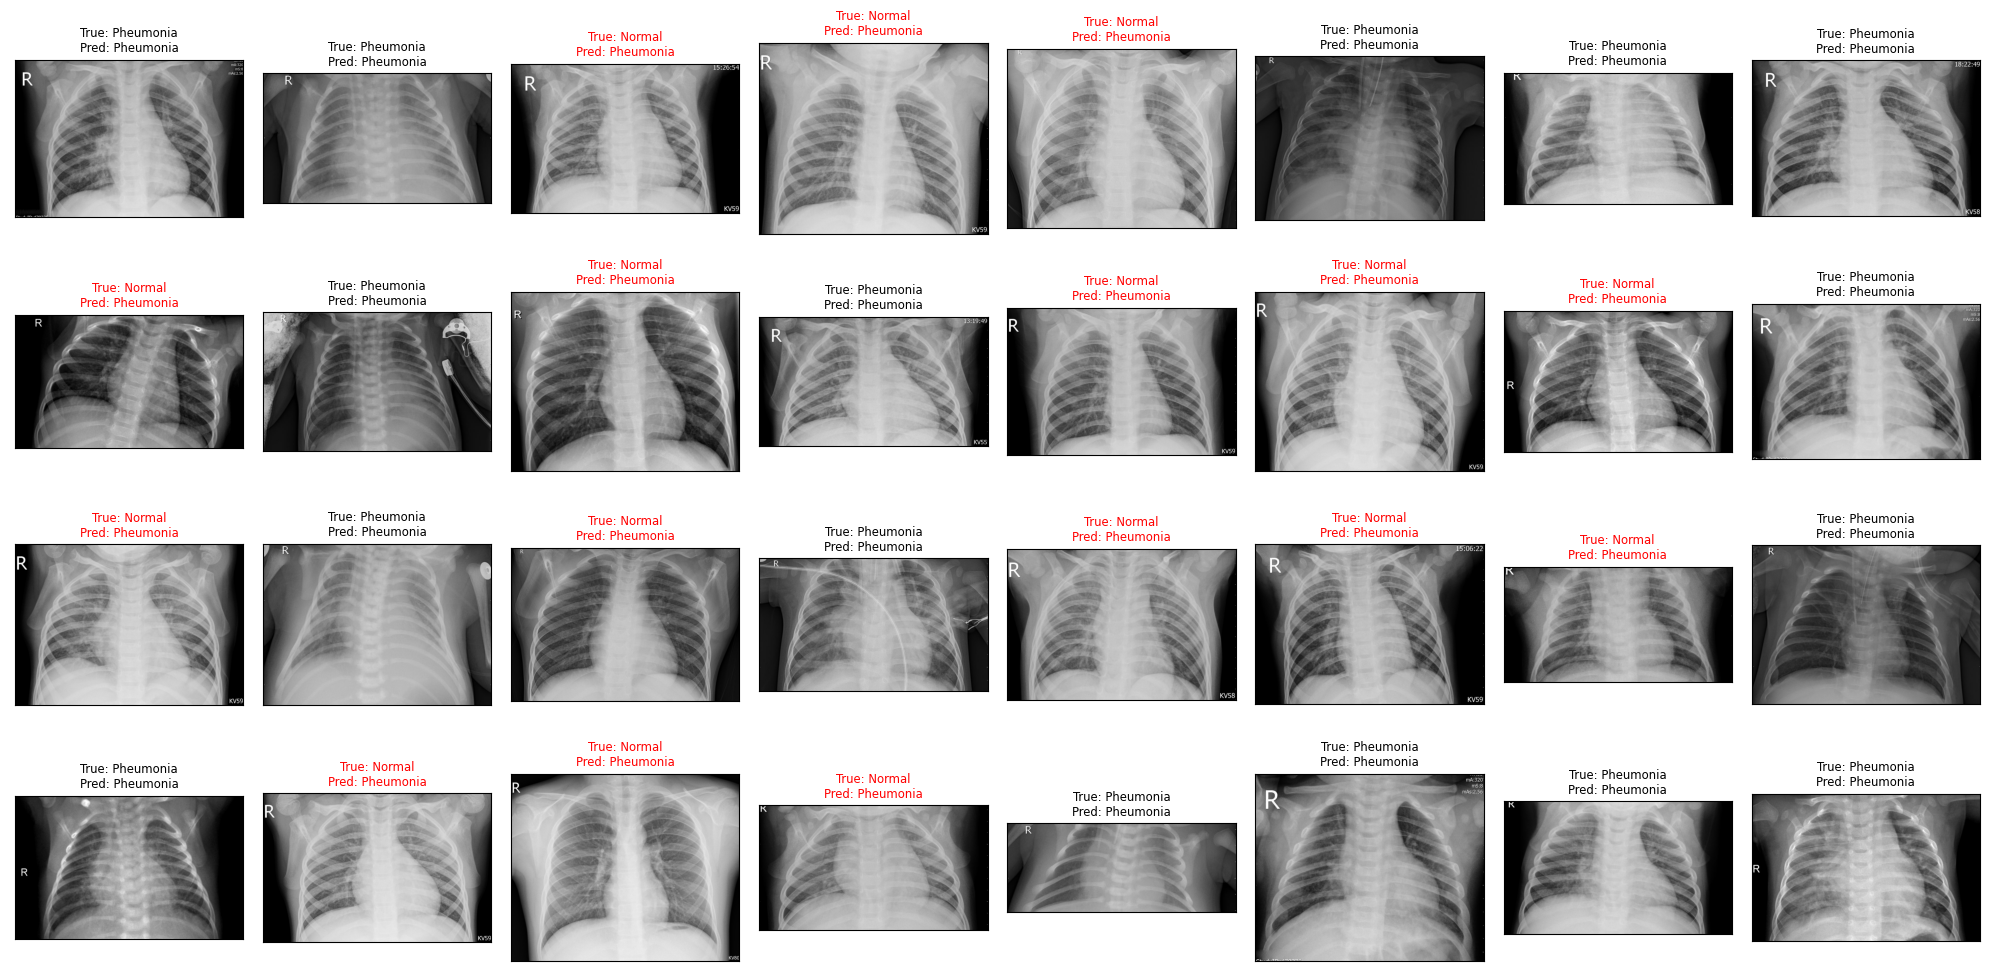

In [183]:
show_predictions(y_img_batch, y_true_batch, y_pred_batch, subplot_params, plot_params, class_map, testing_dir, image_file_name_batch, count=count, sample=True)

## Random

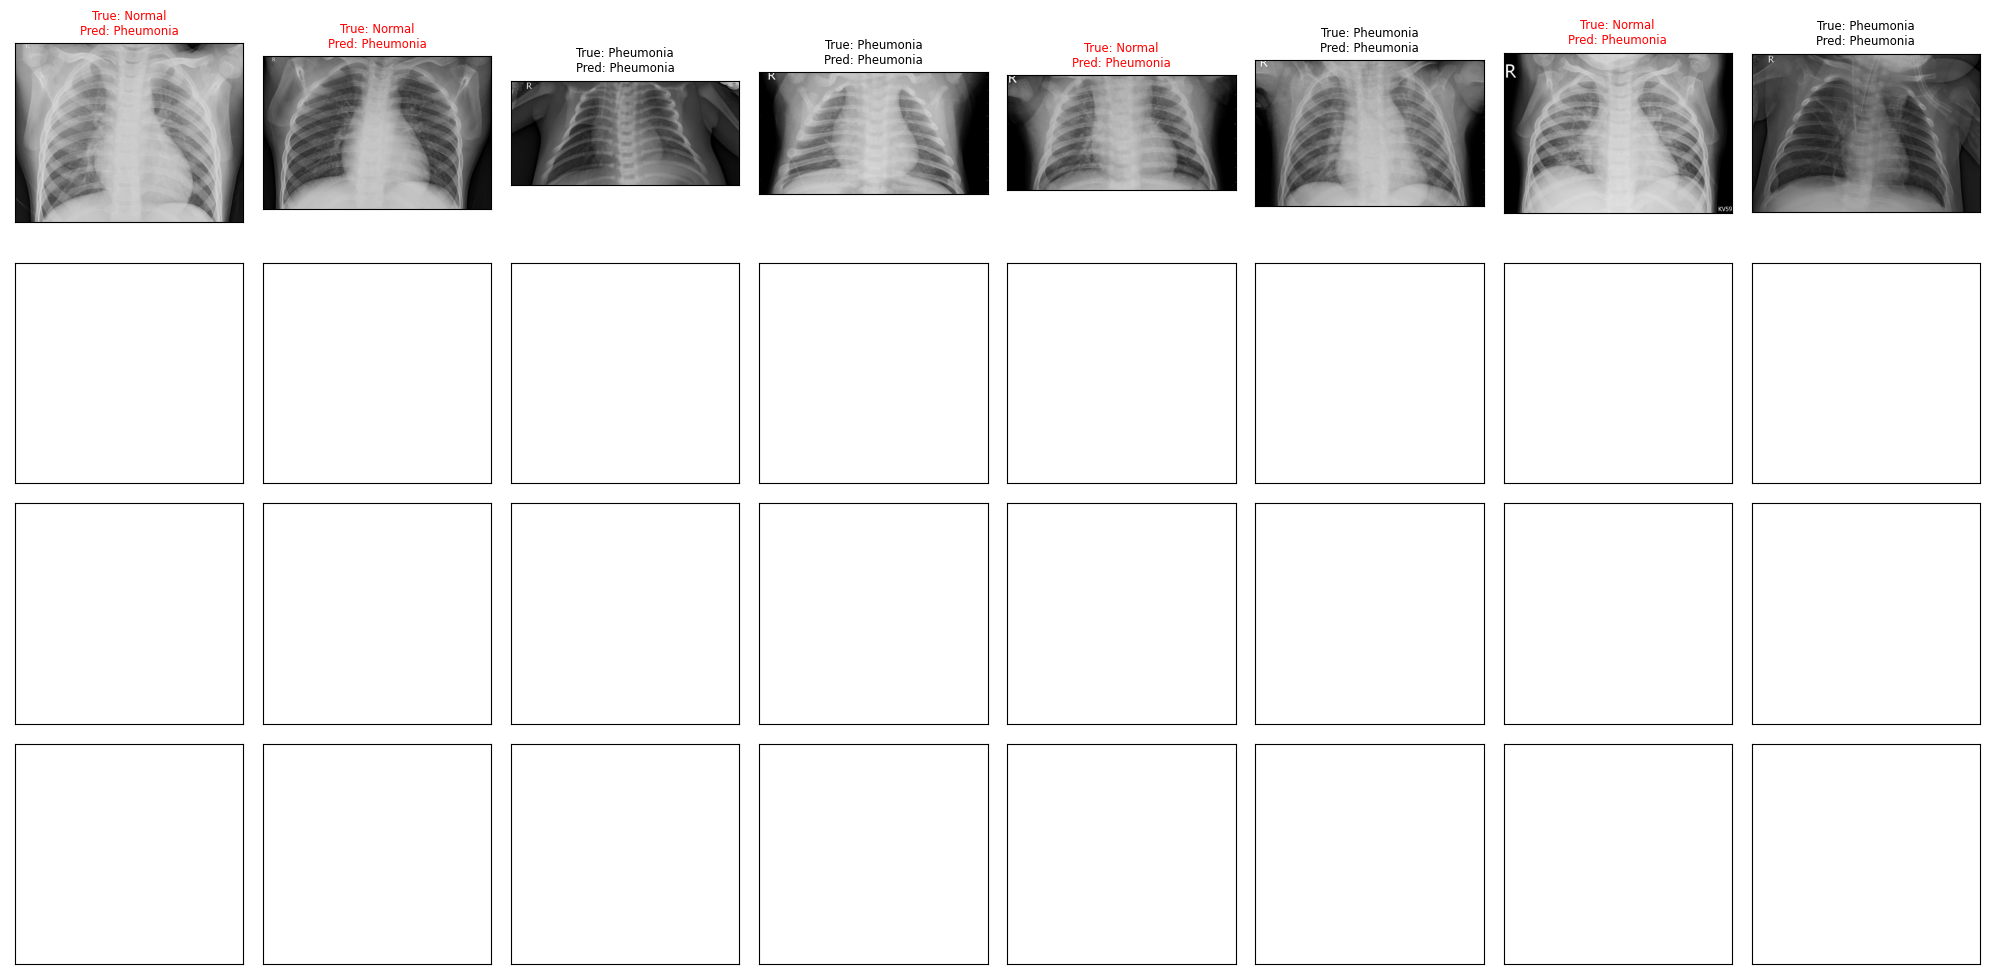

In [184]:
cols = 4
rows = 2

if batch_size_t<4:
    cols = 1
    
count = cols*rows
    

subplot_params = get_reset_subplot_params(nrows, ncols, dpi)
plot_params = get_reset_plot_params()

show_predictions(y_img_batch, y_true_batch, y_pred_batch, subplot_params, plot_params, class_map, testing_dir, image_file_name_sample, count=count, sample=True)